In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
df = pd.read_csv('05-transformed-data.csv')

In [3]:
random_numbers = np.random.random(len(df))
df_small = df[random_numbers < 0.05]
target = df_small.travel_time
features = StandardScaler().fit_transform(df_small.drop('travel_time', axis=1))
features.shape

(29541, 51)

# Evaluation metric
Does the evaluation metric matter?

In [12]:
rf = RandomForestRegressor()
for scorer in ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2']:
    scores = cross_val_score(rf, features, target, scoring=scorer)
    print(scorer + ' score ' + '{:.2f}'.format(scores.mean()))

neg_mean_absolute_error score -3.64
neg_mean_squared_error score -37.24
neg_median_absolute_error score -1.97
r2 score 0.41


In [13]:
rf = GradientBoostingRegressor()
for scorer in ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2']:
    scores = cross_val_score(rf, features, target, scoring=scorer)
    print(scorer + ' score ' + '{:.2f}'.format(scores.mean()))

neg_mean_absolute_error score -3.21
neg_mean_squared_error score -30.54
neg_median_absolute_error score -1.90
r2 score 0.51


The ranking is the same across models for both metrics. Use median absolute error as it is easy to interpret. We would like this value to be less than 1 minute ideally.
Lets see if the model can be tuned to reach that

# Tuning
## Random forest
### How many trees until performance drops off

In [20]:
def random_forest_score(n_trees):
    rf = RandomForestRegressor(n_estimators = n_trees, n_jobs=-1)
    scores = cross_val_score(rf, features, target, scoring='neg_median_absolute_error')
    return(scores.mean())

10
50
100
150
200
250
300


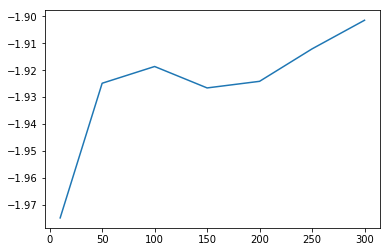

In [21]:
results = []
for n in [10, 50, 100, 150, 200, 250, 300, 350, 400, 450]:
    results.append(random_forest_score(n))
    print(n)

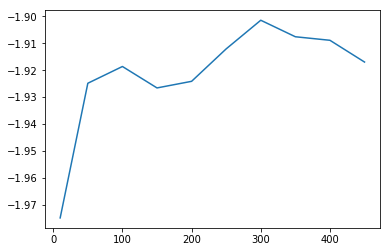

In [25]:
plt.plot([10, 50, 100, 150, 200, 250, 300, 350, 400, 450], results)

## Tune random forest parameters

In [14]:
param_grid = {
    'criterion': ['mse'], # 'mae' was taking too long
    'max_features': [50, 5, 10, 25],
    'max_depth': [None, 3, 5, 10]
}

In [15]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
cv_search = GridSearchCV(rf, param_grid,  
                         scoring='neg_median_absolute_error', cv=3, 
                         verbose=1, error_score = -999 )
cv_search = cv_search.fit(X=features, y=target)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.5min finished


In [16]:
search_results = pd.DataFrame(cv_search.cv_results_)
search_results.sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
8,1.765471,0.107118,-1.850915,-1.766620,mse,5,50,"{'criterion': 'mse', 'max_depth': 5, 'max_feat...",1,-1.799286,-1.942304,-1.809461,-1.727410,-1.943999,-1.630147,0.045124,0.000761,0.065951,0.130419
12,3.782820,0.107267,-1.888595,-1.475507,mse,10,50,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",2,-1.547367,-1.659347,-1.864825,-1.402510,-2.253592,-1.364663,0.249516,0.001997,0.288804,0.130910
15,1.879909,0.107797,-1.890894,-1.481643,mse,10,25,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",3,-1.546735,-1.675521,-1.858748,-1.406877,-2.267198,-1.362531,0.127467,0.001160,0.295005,0.138282
11,0.950799,0.108621,-1.951217,-1.797863,mse,5,25,"{'criterion': 'mse', 'max_depth': 5, 'max_feat...",4,-1.868089,-1.993867,-1.872770,-1.754391,-2.112793,-1.645332,0.049425,0.001112,0.114268,0.145571
14,0.888205,0.107063,-1.991326,-1.533858,mse,10,10,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",5,-1.594746,-1.723815,-1.967359,-1.457329,-2.411872,-1.420431,0.048753,0.000641,0.334020,0.135162
3,3.612387,0.110017,-2.002546,-0.584341,mse,None,25,"{'criterion': 'mse', 'max_depth': None, 'max_f...",6,-1.590809,-0.655754,-1.970000,-0.560000,-2.446829,-0.537269,0.133125,0.000828,0.350225,0.051342
0,6.587474,0.108247,-2.024875,-0.589359,mse,None,50,"{'criterion': 'mse', 'max_depth': None, 'max_f...",7,-1.648215,-0.661686,-1.962099,-0.566392,-2.464310,-0.540000,0.259619,0.002130,0.336113,0.052265
2,1.557852,0.108071,-2.059759,-0.591469,mse,None,10,"{'criterion': 'mse', 'max_depth': None, 'max_f...",8,-1.591012,-0.668312,-2.059327,-0.562306,-2.528940,-0.543790,0.044819,0.001159,0.382908,0.054859
4,1.122202,0.107615,-2.169674,-2.069095,mse,3,50,"{'criterion': 'mse', 'max_depth': 3, 'max_feat...",9,-2.278559,-2.284152,-1.995613,-1.991222,-2.234850,-1.931912,0.004648,0.001746,0.124366,0.153984
1,0.915073,0.109043,-2.308298,-0.625902,mse,None,5,"{'criterion': 'mse', 'max_depth': None, 'max_f...",10,-1.661575,-0.713096,-2.286305,-0.592518,-2.977014,-0.572093,0.005605,0.001185,0.537251,0.062216


In [12]:
param_grid = {
    'criterion': ['mse'], # 'mae' was taking too long
    'max_features': ['auto'],
    'max_depth': [4, 6, 8, 10, 12, 14, 16]
}
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
cv_search = GridSearchCV(rf, param_grid,  
                         scoring='neg_median_absolute_error', cv=3, 
                         verbose=1, error_score = -999 )
cv_search = cv_search.fit(X=features, y=target)
search_results = pd.DataFrame(cv_search.cv_results_)
search_results.sort_values('rank_test_score')

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.4min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,2.078628,0.108147,-1.861791,-1.703909,mse,6,auto,"{'criterion': 'mse', 'max_depth': 6, 'max_feat...",1,-1.720439,-1.895335,-1.819191,-1.634394,-2.045745,-1.581997,0.047801,0.001611,0.136179,0.137039
2,2.792203,0.108683,-1.865271,-1.596944,mse,8,auto,"{'criterion': 'mse', 'max_depth': 8, 'max_feat...",2,-1.595935,-1.796313,-1.826804,-1.524513,-2.173075,-1.470007,0.054606,0.001046,0.237181,0.142720
3,3.894453,0.105878,-1.919738,-1.471361,mse,10,auto,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",3,-1.534065,-1.663460,-1.886182,-1.389443,-2.338967,-1.361181,0.237746,0.001436,0.329455,0.136323
4,4.510031,0.108633,-1.930444,-1.316931,mse,12,auto,"{'criterion': 'mse', 'max_depth': 12, 'max_fea...",4,-1.545043,-1.477616,-1.902525,-1.244916,-2.343765,-1.228261,0.291267,0.000748,0.326674,0.113824
0,1.422994,0.109403,-1.947429,-1.903207,mse,4,auto,"{'criterion': 'mse', 'max_depth': 4, 'max_feat...",5,-1.988411,-2.131844,-1.884776,-1.842069,-1.969100,-1.735708,0.001694,0.001323,0.044998,0.167401
5,5.202246,0.104206,-1.982379,-1.155396,mse,14,auto,"{'criterion': 'mse', 'max_depth': 14, 'max_fea...",6,-1.591274,-1.303665,-1.944508,-1.079833,-2.411354,-1.082690,0.147357,0.000304,0.335866,0.104848
6,5.601079,0.108334,-2.011772,-1.005291,mse,16,auto,"{'criterion': 'mse', 'max_depth': 16, 'max_fea...",7,-1.606769,-1.146702,-1.979769,-0.924086,-2.448778,-0.945086,0.312384,0.001434,0.344493,0.100359


Tuning reduced the median error from 1.97 minutes to 1.86 minutes.

## Boosted Trees tuning

In [18]:
param_grid = {
    'loss': ['ls', 'lad', 'huber'], 
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7, 9],
}
rf = GradientBoostingRegressor(n_estimators=100)
cv_search = GridSearchCV(rf, param_grid,  n_jobs=-1,
                         scoring='neg_median_absolute_error', cv=3, 
                         verbose=2, error_score = -999 )
cv_search = cv_search.fit(X=features, y=target)
search_results = pd.DataFrame(cv_search.cv_results_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] learning_rate=0.01, loss=ls, max_depth=3 ........................
[CV] learning_rate=0.01, loss=ls, max_depth=3 ........................
[CV] learning_rate=0.01, loss=ls, max_depth=3 ........................
[CV] learning_rate=0.01, loss=ls, max_depth=5 ........................
[CV] learning_rate=0.01, loss=ls, max_depth=5 ........................
[CV] learning_rate=0.01, loss=ls, max_depth=5 ........................
[CV] learning_rate=0.01, loss=ls, max_depth=7 ........................
[CV] learning_rate=0.01, loss=ls, max_depth=7 ........................
[CV] ......... learning_rate=0.01, loss=ls, max_depth=3, total=  14.5s
[CV] learning_rate=0.01, loss=ls, max_depth=7 ........................
[CV] ......... learning_rate=0.01, loss=ls, max_depth=3, total=  14.6s
[CV] learning_rate=0.01, loss=ls, max_depth=9 ........................
[CV] ......... learning_rate=0.01, loss=ls, max_depth=3, total=  15.0s
[CV] learning_r

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min


[CV] ...... learning_rate=0.01, loss=huber, max_depth=5, total=  27.2s
[CV] learning_rate=0.01, loss=huber, max_depth=9 .....................
[CV] ...... learning_rate=0.01, loss=huber, max_depth=5, total=  26.6s
[CV] learning_rate=0.01, loss=huber, max_depth=9 .....................
[CV] ........ learning_rate=0.01, loss=lad, max_depth=9, total= 1.3min
[CV] learning_rate=0.01, loss=huber, max_depth=9 .....................
[CV] ........ learning_rate=0.01, loss=lad, max_depth=9, total= 1.3min
[CV] learning_rate=0.05, loss=ls, max_depth=3 ........................
[CV] ...... learning_rate=0.01, loss=huber, max_depth=7, total=  46.8s
[CV] learning_rate=0.05, loss=ls, max_depth=3 ........................
[CV] ......... learning_rate=0.05, loss=ls, max_depth=3, total=  11.0s
[CV] learning_rate=0.05, loss=ls, max_depth=3 ........................
[CV] ...... learning_rate=0.01, loss=huber, max_depth=7, total=  48.5s
[CV] learning_rate=0.05, loss=ls, max_depth=5 ........................
[CV] .

[CV] ......... learning_rate=0.1, loss=lad, max_depth=3, total=  12.7s
[CV] learning_rate=0.1, loss=lad, max_depth=7 ........................
[CV] ......... learning_rate=0.1, loss=lad, max_depth=5, total=  25.0s
[CV] learning_rate=0.1, loss=lad, max_depth=7 ........................
[CV] ......... learning_rate=0.1, loss=lad, max_depth=5, total=  24.4s
[CV] learning_rate=0.1, loss=lad, max_depth=9 ........................
[CV] ......... learning_rate=0.1, loss=lad, max_depth=5, total=  23.8s
[CV] learning_rate=0.1, loss=lad, max_depth=9 ........................
[CV] .......... learning_rate=0.1, loss=ls, max_depth=9, total= 1.2min
[CV] learning_rate=0.1, loss=lad, max_depth=9 ........................
[CV] .......... learning_rate=0.1, loss=ls, max_depth=9, total= 1.2min
[CV] learning_rate=0.1, loss=huber, max_depth=3 ......................
[CV] ......... learning_rate=0.1, loss=lad, max_depth=7, total=  37.9s
[CV] learning_rate=0.1, loss=huber, max_depth=3 ......................
[CV] .

[CV] ....... learning_rate=0.2, loss=huber, max_depth=7, total=  44.1s
[CV] learning_rate=0.5, loss=ls, max_depth=5 .........................
[CV] .......... learning_rate=0.5, loss=ls, max_depth=3, total=  12.2s
[CV] learning_rate=0.5, loss=ls, max_depth=7 .........................
[CV] ....... learning_rate=0.2, loss=huber, max_depth=7, total=  41.3s
[CV] learning_rate=0.5, loss=ls, max_depth=7 .........................
[CV] .......... learning_rate=0.5, loss=ls, max_depth=5, total=  23.7s
[CV] learning_rate=0.5, loss=ls, max_depth=7 .........................
[CV] .......... learning_rate=0.5, loss=ls, max_depth=5, total=  23.2s
[CV] learning_rate=0.5, loss=ls, max_depth=9 .........................


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.8min


[CV] .......... learning_rate=0.5, loss=ls, max_depth=5, total=  24.0s
[CV] learning_rate=0.5, loss=ls, max_depth=9 .........................
[CV] .......... learning_rate=0.5, loss=ls, max_depth=7, total=  39.2s
[CV] learning_rate=0.5, loss=ls, max_depth=9 .........................
[CV] ....... learning_rate=0.2, loss=huber, max_depth=9, total= 1.2min
[CV] learning_rate=0.5, loss=lad, max_depth=3 ........................
[CV] ....... learning_rate=0.2, loss=huber, max_depth=9, total= 1.2min
[CV] learning_rate=0.5, loss=lad, max_depth=3 ........................
[CV] ....... learning_rate=0.2, loss=huber, max_depth=9, total= 1.2min
[CV] learning_rate=0.5, loss=lad, max_depth=3 ........................
[CV] .......... learning_rate=0.5, loss=ls, max_depth=7, total=  38.4s
[CV] learning_rate=0.5, loss=lad, max_depth=5 ........................
[CV] .......... learning_rate=0.5, loss=ls, max_depth=7, total=  37.5s
[CV] learning_rate=0.5, loss=lad, max_depth=5 ........................
[CV] .

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 14.3min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_loss,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
16,12.408733,0.042510,-1.727872,-1.621358,0.05,lad,3,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",1,-1.470123,-1.842604,-1.768484,-1.551389,-1.945008,-1.470083,0.562040,0.003591,0.195986,0.159926
17,26.386224,0.068124,-1.731935,-1.482099,0.05,lad,5,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",2,-1.513285,-1.651843,-1.756297,-1.430296,-1.926222,-1.364159,0.340439,0.007063,0.169459,0.123026
21,26.615493,0.068937,-1.791853,-1.558861,0.05,huber,5,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",3,-1.524351,-1.743231,-1.853912,-1.502879,-1.997297,-1.430474,0.381171,0.003982,0.198003,0.133678
20,13.447075,0.051025,-1.803263,-1.674368,0.05,huber,3,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",4,-1.590906,-1.871494,-1.803082,-1.607305,-2.015801,-1.544305,0.313712,0.003979,0.173462,0.141742
18,43.138781,0.077171,-1.814402,-1.307753,0.05,lad,7,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",5,-1.730167,-1.446984,-1.748325,-1.257051,-1.964714,-1.219225,0.564184,0.003952,0.106545,0.099655
19,71.895877,0.086622,-1.841387,-1.099265,0.05,lad,9,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",6,-1.801479,-1.209665,-1.779027,-1.044392,-1.943655,-1.043736,0.833252,0.002965,0.072893,0.078066
28,12.452810,0.058001,-1.842384,-1.583146,0.1,lad,3,"{'learning_rate': 0.1, 'loss': 'lad', 'max_dep...",7,-1.462753,-1.759570,-1.799038,-1.531443,-2.265361,-1.458426,0.168182,0.002616,0.329093,0.128262
6,42.987909,0.078316,-1.859638,-1.696569,0.01,lad,7,"{'learning_rate': 0.01, 'loss': 'lad', 'max_de...",8,-1.789523,-1.886022,-1.826049,-1.626721,-1.963342,-1.576964,1.424292,0.006486,0.074831,0.135495
5,26.389244,0.060126,-1.861144,-1.748419,0.01,lad,5,"{'learning_rate': 0.01, 'loss': 'lad', 'max_de...",9,-1.841710,-1.941143,-1.811980,-1.675511,-1.929742,-1.628602,0.691079,0.002123,0.050001,0.137616
10,47.258625,0.094043,-1.897742,-1.749878,0.01,huber,7,"{'learning_rate': 0.01, 'loss': 'huber', 'max_...",10,-1.814639,-1.954869,-1.891613,-1.671992,-1.986974,-1.622775,0.847066,0.011767,0.070489,0.146336


In [19]:
search_results.sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_loss,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
16,12.408733,0.042510,-1.727872,-1.621358,0.05,lad,3,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",1,-1.470123,-1.842604,-1.768484,-1.551389,-1.945008,-1.470083,0.562040,0.003591,0.195986,0.159926
17,26.386224,0.068124,-1.731935,-1.482099,0.05,lad,5,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",2,-1.513285,-1.651843,-1.756297,-1.430296,-1.926222,-1.364159,0.340439,0.007063,0.169459,0.123026
21,26.615493,0.068937,-1.791853,-1.558861,0.05,huber,5,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",3,-1.524351,-1.743231,-1.853912,-1.502879,-1.997297,-1.430474,0.381171,0.003982,0.198003,0.133678
20,13.447075,0.051025,-1.803263,-1.674368,0.05,huber,3,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",4,-1.590906,-1.871494,-1.803082,-1.607305,-2.015801,-1.544305,0.313712,0.003979,0.173462,0.141742
18,43.138781,0.077171,-1.814402,-1.307753,0.05,lad,7,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",5,-1.730167,-1.446984,-1.748325,-1.257051,-1.964714,-1.219225,0.564184,0.003952,0.106545,0.099655
19,71.895877,0.086622,-1.841387,-1.099265,0.05,lad,9,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",6,-1.801479,-1.209665,-1.779027,-1.044392,-1.943655,-1.043736,0.833252,0.002965,0.072893,0.078066
28,12.452810,0.058001,-1.842384,-1.583146,0.1,lad,3,"{'learning_rate': 0.1, 'loss': 'lad', 'max_dep...",7,-1.462753,-1.759570,-1.799038,-1.531443,-2.265361,-1.458426,0.168182,0.002616,0.329093,0.128262
6,42.987909,0.078316,-1.859638,-1.696569,0.01,lad,7,"{'learning_rate': 0.01, 'loss': 'lad', 'max_de...",8,-1.789523,-1.886022,-1.826049,-1.626721,-1.963342,-1.576964,1.424292,0.006486,0.074831,0.135495
5,26.389244,0.060126,-1.861144,-1.748419,0.01,lad,5,"{'learning_rate': 0.01, 'loss': 'lad', 'max_de...",9,-1.841710,-1.941143,-1.811980,-1.675511,-1.929742,-1.628602,0.691079,0.002123,0.050001,0.137616
10,47.258625,0.094043,-1.897742,-1.749878,0.01,huber,7,"{'learning_rate': 0.01, 'loss': 'huber', 'max_...",10,-1.814639,-1.954869,-1.891613,-1.671992,-1.986974,-1.622775,0.847066,0.011767,0.070489,0.146336


In [20]:
param_grid = {
    'loss': ['lad'], 
    'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08],
    'max_depth': [2, 3, 4],
}
rf = GradientBoostingRegressor(n_estimators=100)
cv_search = GridSearchCV(rf, param_grid,  n_jobs=-1,
                         scoring='neg_median_absolute_error', cv=3, 
                         verbose=1, error_score = -999 )
cv_search = cv_search.fit(X=features, y=target)
search_results = pd.DataFrame(cv_search.cv_results_)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:  2.4min finished


In [21]:
search_results.sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_loss,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,26.222965,0.081922,-1.714980,-1.545492,0.05,lad,4,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",1,-1.424364,-1.733693,-1.774675,-1.483623,-1.945901,-1.419161,0.871684,0.002927,0.217060,0.135655
8,27.621830,0.085226,-1.722834,-1.568248,0.04,lad,4,"{'learning_rate': 0.04, 'loss': 'lad', 'max_de...",2,-1.456667,-1.769218,-1.770633,-1.496067,-1.941201,-1.439458,0.507786,0.006160,0.200677,0.143975
10,18.580471,0.080684,-1.727872,-1.621358,0.05,lad,3,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",3,-1.470123,-1.842604,-1.768484,-1.551389,-1.945008,-1.470083,0.755685,0.004594,0.195986,0.159926
5,26.586580,0.080759,-1.728592,-1.590066,0.03,lad,4,"{'learning_rate': 0.03, 'loss': 'lad', 'max_de...",4,-1.493710,-1.785464,-1.772486,-1.523460,-1.919579,-1.461274,0.279504,0.005847,0.176609,0.140480
14,24.677033,0.077537,-1.728822,-1.527976,0.06,lad,4,"{'learning_rate': 0.06, 'loss': 'lad', 'max_de...",5,-1.451144,-1.710497,-1.764573,-1.462963,-1.970749,-1.410469,0.307821,0.005424,0.213629,0.130829
16,16.701888,0.072255,-1.736207,-1.591168,0.07,lad,3,"{'learning_rate': 0.07, 'loss': 'lad', 'max_de...",6,-1.474864,-1.780908,-1.764739,-1.530380,-1.969019,-1.462217,0.346410,0.001946,0.202744,0.137022
7,18.252835,0.072834,-1.742898,-1.625550,0.04,lad,3,"{'learning_rate': 0.04, 'loss': 'lad', 'max_de...",7,-1.525615,-1.828152,-1.771541,-1.561803,-1.931538,-1.486694,0.407993,0.001710,0.166951,0.146506
13,16.971516,0.073036,-1.743265,-1.608167,0.06,lad,3,"{'learning_rate': 0.06, 'loss': 'lad', 'max_de...",8,-1.476378,-1.799321,-1.787186,-1.547519,-1.966231,-1.477661,0.627890,0.003771,0.202379,0.138142
19,15.902358,0.042355,-1.749982,-1.587997,0.08,lad,3,"{'learning_rate': 0.08, 'loss': 'lad', 'max_de...",9,-1.493245,-1.773996,-1.794928,-1.525015,-1.961772,-1.464980,0.844521,0.009739,0.193898,0.133786
2,24.232171,0.085287,-1.757774,-1.628529,0.02,lad,4,"{'learning_rate': 0.02, 'loss': 'lad', 'max_de...",10,-1.592911,-1.819346,-1.757121,-1.559329,-1.923288,-1.506912,0.324322,0.004966,0.134877,0.136614


In [22]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000]
}
rf = GradientBoostingRegressor(learning_rate=0.05, loss='lad', max_depth=4)
cv_search = GridSearchCV(rf, param_grid,  n_jobs=-1,
                         scoring='neg_median_absolute_error', cv=3, 
                         verbose=1, error_score = -999 )
cv_search = cv_search.fit(X=features, y=target)
search_results = pd.DataFrame(cv_search.cv_results_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.3min remaining:   27.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.4min finished


In [23]:
search_results.sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,24.574056,0.085801,-1.716892,-1.547717,100,{'n_estimators': 100},1,-1.419683,-1.741488,-1.773855,-1.483623,-1.957139,-1.418038,0.655538,0.005772,0.223082,0.139609
1,45.221561,0.139947,-1.934812,-1.498780,200,{'n_estimators': 200},2,-1.586267,-1.668713,-1.756489,-1.440745,-2.461679,-1.386882,0.928375,0.010524,0.378977,0.122156
2,86.080503,0.206450,-2.396435,-1.460645,500,{'n_estimators': 500},3,-3.070807,-1.626476,-1.774152,-1.399377,-2.344347,-1.356082,5.620712,0.052460,0.530637,0.118585
3,107.921420,0.129704,-2.441714,-1.453522,1000,{'n_estimators': 1000},4,-2.762014,-1.606037,-1.747245,-1.406245,-2.815884,-1.348283,7.728034,0.025758,0.491556,0.110410


Boosted trees can be tuned to 1.7 minutes median error